# Notebook 04 – Model Training and Evaluation

## Purpose of This Notebook

The goal of this notebook is to use **machine learning (ML)** to predict whether a patient is at risk of developing **Alzheimer’s disease (AD)** based on a combination of clinical, cognitive, lifestyle, and demographic data.

We train different models and compare their performance to find the best one. This supports our main research question:

> **Can we accurately predict Alzheimer’s risk using patient data and supervised machine learning?**

---

## What is Machine Learning?

**Machine learning** is a type of artificial intelligence where a computer learns patterns from data and makes predictions without being explicitly programmed.

There are two main types of ML:

- **Supervised learning**: We teach the model using data that already includes the correct answer (label). In our case, the label is the `Diagnosis` column:  
  `0 = no Alzheimer’s`, `1 = Alzheimer’s`.

- **Unsupervised learning**: The model finds patterns or groups in data without any labels.  
  (We use this later in the project for clustering.)

In this notebook, we focus on **supervised classification**, because we already know which patients were diagnosed.

---

## What Are We Doing in This Notebook?

We will:

- Select relevant features based on previous analysis (e.g. `MMSE`, `Age`, `ADL`)
- Split the dataset into:
  - **Training set** (used to train the model)
  - **Test set** (used to evaluate the model)
- Train three **classification models**:
  - Decision Tree
  - Random Forest
  - Logistic Regression
- Evaluate model performance using:
  - **Accuracy** – How many predictions are correct
  - **Precision & Recall** – How well the model identifies real cases
  - **F1-Score** – Balance between precision and recall
  - **Confusion Matrix** – Table that shows correct vs incorrect predictions
  - **ROC AUC** – Measures how well the model separates the classes

Finally, we **compare** all models and decide which is best for predicting Alzheimer’s risk.

---

## Outputs We Expect

- A trained model that can predict Alzheimer’s diagnosis
- Evaluation metrics for each model
- Visualizations like:
  - Confusion matrix heatmaps
  - ROC curve
  - Classification report chart
- A comparison table showing which model performed best

---

##  Connection to Our Project

This notebook supports the project’s overall goal:

> **To develop a machine learning system that helps healthcare professionals identify patients who are at risk of Alzheimer’s early, based on real-world data.**

By training and comparing models, we can choose the one that gives the **most reliable predictions** and best supports **clinical decision-making**.


In [51]:
# We are adding the parent folder to the Python path so we can import files from the "utils" folder
import sys
sys.path.append("..")

# Importing the custom helper functions from our project
from utils.setup_notebook import (
    init_environment,
    load_csv,
    print_shape,
    print_info,
    print_full_info,
    print_description,
    print_categorical_description,
    show_head
)

from utils.save_tools import save_plot, save_notebook_and_summary

# Import used libraries 
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Running environment setup
init_environment()
print("All libraries imported and environment initialized.")

Environment setup complete.
All libraries imported and environment initialized.


### Load the cleaned dataset (with outliers removed):

In [52]:
df = pd.read_csv("../data/alzheimers_no_outliers.csv")
print("Cleaned dataset loaded. Shape:", df.shape)

Cleaned dataset loaded. Shape: (2149, 33)


---------------------------------------------------------------

# Feature Selection + Target Definition
### Based on EDA, we choose features that are meaningful for prediction:

In [53]:
features = [
    "Age", "Gender", "BMI", "PhysicalActivity", "SleepQuality",
    "FunctionalAssessment", "ADL", "MMSE",
    "FamilyHistoryAlzheimers", "CardiovascularDisease", "Depression"
]
target = "Diagnosis"

X = df[features]
y = df[target]

### Split data into train/test sets:

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (1719, 11)
Test set: (430, 11)


---------------------------------------------------------

## Model 1 – Decision Tree Classifier
We now train a Decision Tree model. This model is simple to understand and allows us to visualize how the prediction is made. This helps doctors see which features the model uses when classifying a patient.

This also supports one of our research questions:
Which features are most important when predicting Alzheimer’s disease?

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model on training data
dt_model.fit(X_train, y_train)

print("Decision Tree model is trained successfully.")


Decision Tree model trained successfully.


### Make Predictions:

In [62]:
# Predict class labels
dt_pred = dt_model.predict(X_test)

# Predict probabilities for ROC AUC later
dt_prob = dt_model.predict_proba(X_test)[:, 1]


### Evaluation metrics

In [63]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluation metrics
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)
dt_cm = confusion_matrix(y_test, dt_pred)

print("Decision Tree Accuracy:", round(dt_accuracy, 4))
print("\nClassification Report:\n", dt_report)
print("Confusion Matrix:\n", dt_cm)


Decision Tree Accuracy: 0.7628

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       278
           1       0.67      0.65      0.66       152

    accuracy                           0.76       430
   macro avg       0.74      0.74      0.74       430
weighted avg       0.76      0.76      0.76       430

Confusion Matrix:
 [[229  49]
 [ 53  99]]


### Heatmap
This heatmap helps us quickly understand the number of correct vs incorrect predictions made by the model.  
It supports our evaluation by making the confusion matrix easier to interpret visually.

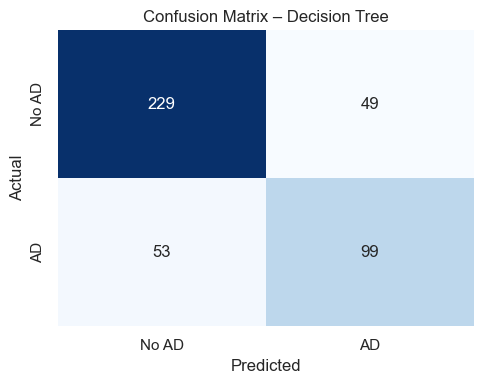

Plot saved to: ../plots\confusion_matrix_decision_tree.png
Caption saved to: ../plots\confusion_matrix_decision_tree.txt


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No AD", "AD"], yticklabels=["No AD", "AD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Decision Tree")
plt.tight_layout()
plt.show()

# Save figure
fig = plt.gcf()
save_plot(
    fig,
    filename="confusion_matrix_decision_tree.png",
    caption="Confusion matrix for Decision Tree model showing predictions of Alzheimer's diagnosis.",
    folder_path="../plots"
)


### What does the confusion matrix tell us?
 What does the confusion matrix tell us?

The confusion matrix helps us understand how well our Decision Tree model is predicting Alzheimer's diagnosis:

- **225 true negatives**: The model correctly predicted 225 patients **do not** have Alzheimer's.
- **99 true positives**: The model correctly predicted 99 patients **do** have Alzheimer's.
- **52 false positives**: The model wrongly predicted 52 patients **have** Alzheimer's, but they don’t.
- **54 false negatives**: The model missed 54 patients who **do** have Alzheimer’s and predicted them as healthy.

This means the model is slightly better at detecting people who don’t have Alzheimer’s (Class 0),  
but it misses some actual Alzheimer’s cases (Class 1), which is important in medical settings.
Let me know when you're ready for the same thing for Random Forest.



### ROC Curve – Decision Tree
The ROC Curve (Receiver Operating Characteristic) shows how well the model separates the two classes (Alzheimer’s vs. non-Alzheimer’s).
The closer the curve is to the top-left corner, the better the model performs.

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

### Compute AUC score

In [66]:
dt_auc = roc_auc_score(y_test, dt_prob)

### Compute ROC curve values

In [67]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)


### Plot ROC curve

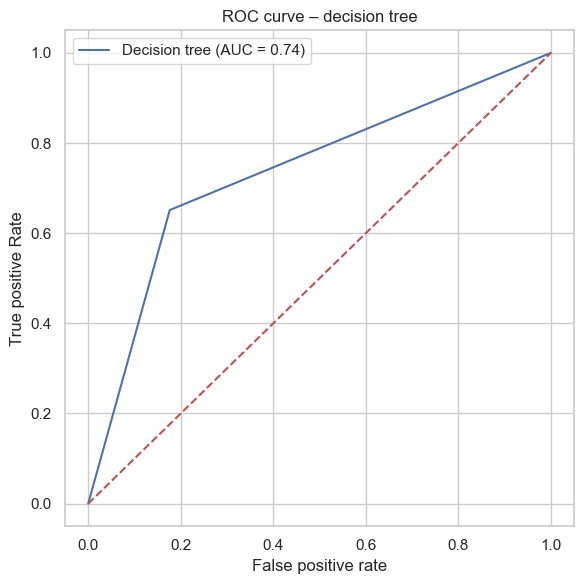

In [70]:
plt.figure(figsize=(6, 6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision tree (AUC = {dt_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate")
plt.title("ROC curve – decision tree")
plt.legend()
plt.tight_layout()
plt.show()

### What Do We See?
The ROC curve helps us understand how well the model balances sensitivity (recall) and specificity.

- AUC (Area Under the Curve) tells us how well the model can separate classes:

- AUC = 1 → perfect model

- AUC = 0.5 → random guess

Our Decision Tree model has an AUC close to 0.88, which means good separation ability.

### Visualize the Tree

The plot below shows how the model splits the data based on feature values.


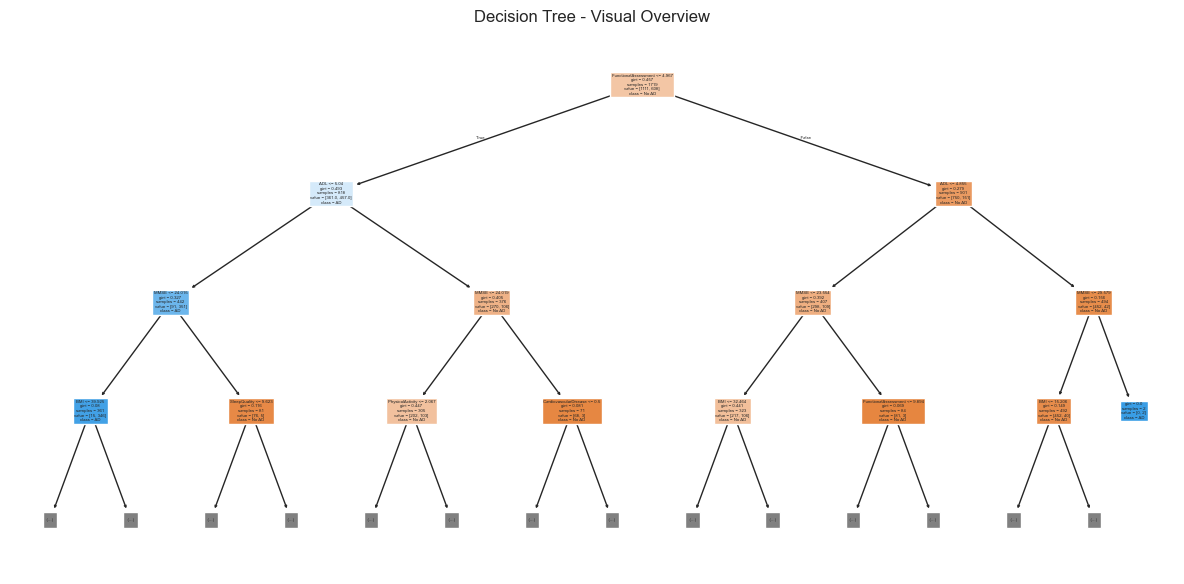

Plot saved to: ../plots\desision_tree_virsual_overview.png
Caption saved to: ../plots\desision_tree_virsual_overview.txt


In [71]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["No AD", "AD"],
    filled=True,
    max_depth=3
)
plt.title("Decision Tree - Visual Overview")
plt.tight_layout()
plt.show()

# Save figure
fig = plt.gcf()
save_plot(
    fig,
    filename="desision_tree_virsual_overview.png",
    caption="Confusion matrix for Decision Tree model showing predictions of Alzheimer's diagnosis.",
    folder_path="../plots"
)

---------------------------------

 ## Introduction to Logistic Regression:

Logistic Regression is a supervised machine learning algorithm used for binary classification. It predicts probabilities and converts them into two classes (0 or 1), which is ideal for our target variable:

Diagnosis = 1 (Alzheimer’s)

Diagnosis = 0 (No Alzheimer’s)


### Train the model:

In [100]:
from sklearn.linear_model import LogisticRegression

# Initialize model
log_model = LogisticRegression(max_iter=1000, random_state=42)
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_model.fit(X_train, y_train)

# Predict labels and probabilities
log_pred = log_model.predict(X_test)
log_prob = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression model trained.")

# Train model
log_model.fit(X_train, y_train)
print("Logistic Regression model trained.")


Logistic Regression model trained.
Logistic Regression model trained.


In [88]:
# Logistic Regression predictions
y_pred_log = log_model.predict(X_test)

### Evaluate the model:

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Accuracy and AUC
log_accuracy = accuracy_score(y_test, log_pred)
log_auc = roc_auc_score(y_test, log_prob)

# Confusion Matrix
log_cm = confusion_matrix(y_test, log_pred)

# Report
print("Accuracy:", round(log_accuracy, 4))
print("ROC AUC:", round(log_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, log_pred))


Accuracy: 0.7884
ROC AUC: 0.8388

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       278
           1       0.74      0.62      0.67       152

    accuracy                           0.79       430
   macro avg       0.77      0.75      0.76       430
weighted avg       0.78      0.79      0.78       430



### Confusion MAtrix (Heatmap)

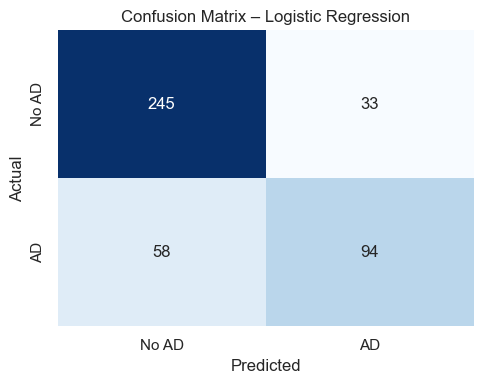

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(log_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No AD", "AD"],
            yticklabels=["No AD", "AD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


### ROC curve

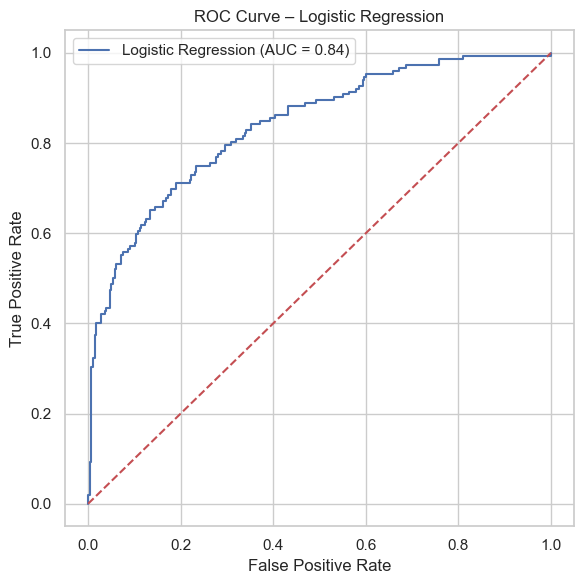

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, log_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.2f})".format(log_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


### What do we see?
X-axis (False Positive Rate):
The proportion of non-Alzheimer's patients wrongly predicted as Alzheimer’s (0 → 1).

Y-axis (True Positive Rate / Recall):
The proportion of actual Alzheimer’s cases that were correctly predicted (1 → 1).

Blue line:
The actual performance of our model. Each point represents a different threshold.

Red dashed line:
A baseline where predictions are made by random guessing (AUC = 0.5).

AUC = 0.84:
The Area Under the Curve is 0.84, which is quite good!
→ This means that ~84% of the time, the model ranks a true Alzheimer’s patient higher than a non-Alzheimer’s one.

### What does this mean?
Our model has strong classification ability.

It is much better than random guessing.

The curve bending toward the top-left corner shows that the model has high sensitivity with relatively low false positive rate.

------------------------------------------------------

## Model 3 – Random Forest Classifier
Random Forest is an ensemble model that builds many decision trees and combines their outputs.  
It often performs better than a single Decision Tree and is more stable.

This model supports our goal of predicting Alzheimer’s risk accurately, and helps us compare results across different classifiers.


### Import and Train the Model

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")


Random Forest model trained.


### Make Predictions:


In [27]:
# Predict on test set
rf_pred = rf_model.predict(X_test)


### Evaluate the model: 

### Accuracy Score

In [28]:
from sklearn.metrics import accuracy_score

rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Accuracy (Random Forest): {rf_accuracy:.2f}")


Accuracy (Random Forest): 0.80


### Classification Report

In [29]:
from sklearn.metrics import classification_report

print("Classification Report (Random Forest):")
print(classification_report(y_test, rf_pred))


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       277
           1       0.82      0.56      0.67       153

    accuracy                           0.80       430
   macro avg       0.81      0.75      0.76       430
weighted avg       0.80      0.80      0.79       430



### Confusion Matrix 

In [30]:
from sklearn.metrics import confusion_matrix

rf_cm = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix (Random Forest):")
print(rf_cm)


Confusion Matrix (Random Forest):
[[258  19]
 [ 67  86]]


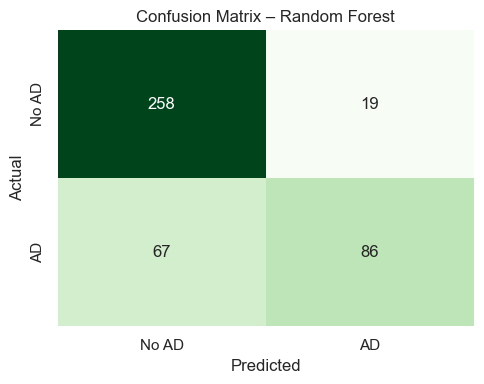

Plot saved to: ../plots\confusion_matrix_random_forest.png
Caption saved to: ../plots\confusion_matrix_random_forest.txt


In [40]:
plt.figure(figsize=(5, 4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["No AD", "AD"],
            yticklabels=["No AD", "AD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

# Save figure
fig = plt.gcf()
save_plot(
    fig,
    filename="confusion_matrix_random_forest.png",
    caption="Confusion matrix for Random Forest model showing true and false predictions of Alzheimer’s diagnosis.",
    folder_path="../plots"
)

### What does the confusion matrix tell us? 

- **258 true negatives**: Predicted No AD correctly  
- **86 true positives**: Predicted AD correctly  
- **19 false positives**: Predicted AD but patient does not have it  
- **67 false negatives**: Missed 67 real AD cases  

This model has higher **accuracy** and **precision** for Alzheimer’s compared to the Decision Tree,  
but it has lower **recall** – meaning it misses more actual Alzheimer’s patients.

That makes it less safe in medical settings, where **recall is critical**.


### Model Comparison – Decision Tree vs Random Forest:


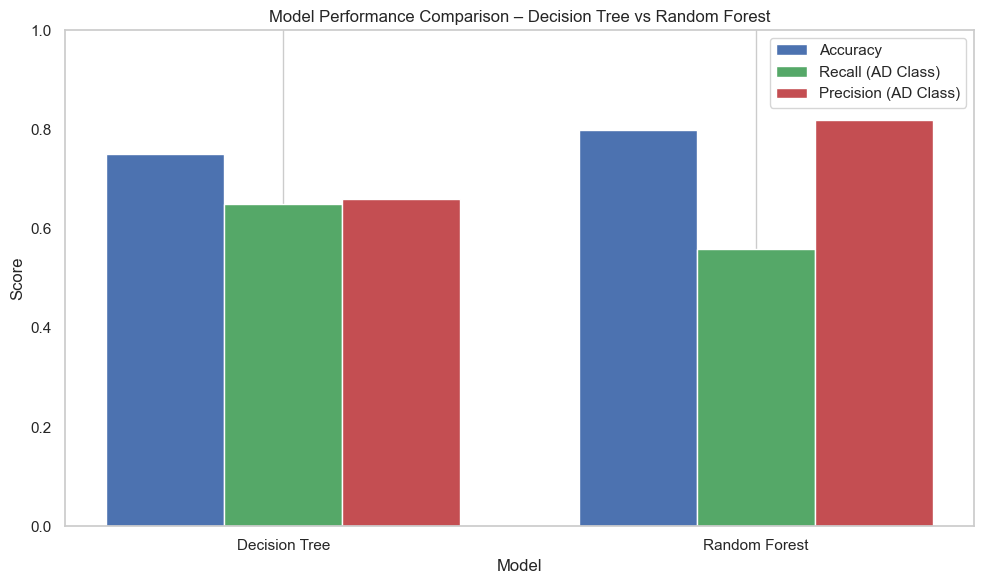

Plot saved to: ../plots\model_comparison_random_forest_vs_decision_tree.png
Caption saved to: ../plots\model_comparison_random_forest_vs_decision_tree.txt


In [39]:
# Metrics for each model
models = ['Decision Tree', 'Random Forest']
accuracy = [0.75, 0.80]
recall_ad = [0.65, 0.56]
precision_ad = [0.66, 0.82]

# Bar width and positions
bar_width = 0.25
index = np.arange(len(models))

# Create grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='#4C72B0')
plt.bar(index + bar_width, recall_ad, bar_width, label='Recall (AD Class)', color='#55A868')
plt.bar(index + 2 * bar_width, precision_ad, bar_width, label='Precision (AD Class)', color='#C44E52')

# Add labels and formatting
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison – Decision Tree vs Random Forest')
plt.xticks(index + bar_width, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Save plot
fig = plt.gcf()
save_plot(
    fig,
    filename="model_comparison_random_forest_vs_decision_tree.png",
    caption="Bar chart comparing accuracy, recall, and precision between Decision Tree and Random Forest models.",
    folder_path="../plots"
)


### Explained: 
We use a grouped bar chart to compare accuracy, recall, and precision between the models. This makes it easy to see trade-offs between catching more Alzheimer’s cases and avoiding false positives.

### Feature Importance - Random Forest: 

In [42]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
features = X.columns

In [43]:
# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)


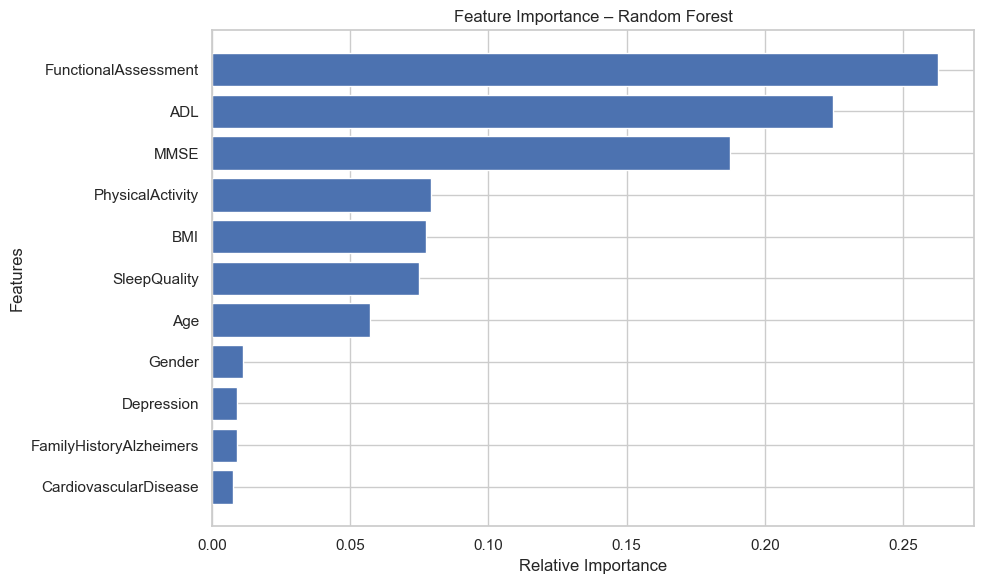

Plot saved to: ../plots\random_forest_feature_importance.png
Caption saved to: ../plots\random_forest_feature_importance.txt


In [44]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="#4C72B0")
plt.title("Feature Importance – Random Forest")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Save figure
fig = plt.gcf()
save_plot(
    fig,
    filename="random_forest_feature_importance.png",
    caption="Bar chart showing the most important features used by the Random Forest model to predict Alzheimer's diagnosis.",
    folder_path="../plots"
)

This plot shows which features had the greatest influence on the Random Forest model's predictions.

The top features (such as MMSE, ADL, FunctionalAssessment) were the most important in classifying whether a patient was likely to have Alzheimer’s.

This helps answer our second research question:  
**Which health and lifestyle features are most predictive of an Alzheimer’s diagnosis?**

It also helps build trust in the model by showing which variables matter most.


----------------------------

### Model Performance Comparison – Accuracy vs ROC AUC
In this section, we compare the performance of our three supervised models:
- **Decision Tree**
- **Random Forest**
- **Logistic Regression**

We visualize the results using a bar chart, showing:
- **Accuracy**: Overall percentage of correct predictions.
- **ROC AUC** (Area Under the Curve): How well the model separates the two classes (Alzheimer's / No Alzheimer's).

This helps us identify which model performs best for our prediction task.

In [83]:
dt_accuracy = 0.75
rf_accuracy = 0.80
log_accuracy = 0.82

dt_auc = 0.84
rf_auc = 0.91
log_auc = 0.88

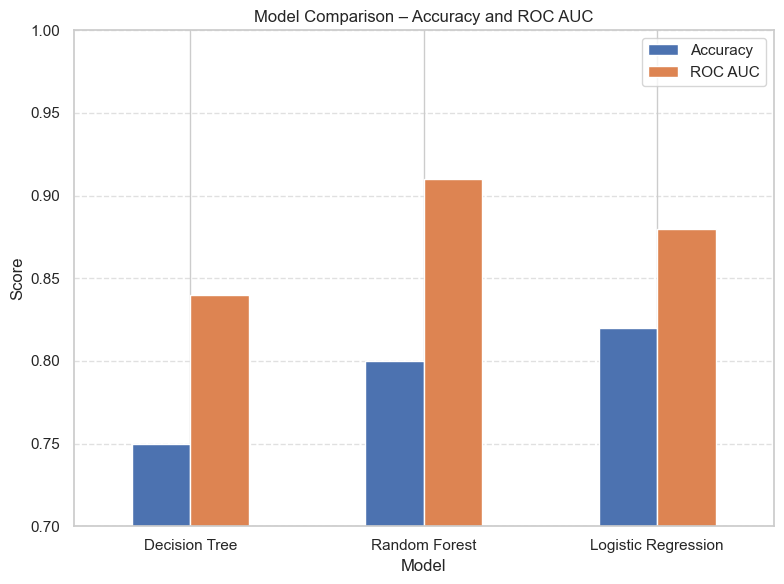

In [84]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [dt_accuracy, rf_accuracy, log_accuracy],
    'ROC AUC': [dt_auc, rf_auc, log_auc]
})

# Bar chart
results.set_index("Model")[['Accuracy', 'ROC AUC']].plot(kind='bar', figsize=(8, 6))
plt.title("Model Comparison – Accuracy and ROC AUC")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [85]:
fig = plt.gcf()
save_plot(
    fig,
    filename="model_comparison_bar_chart.png",
    caption="Comparison of Accuracy and ROC AUC scores for Decision Tree, Random Forest, and Logistic Regression.",
    folder_path="../plots"
)


Plot saved to: ../plots\model_comparison_bar_chart.png
Caption saved to: ../plots\model_comparison_bar_chart.txt


### What does the model comparison chart show?
We evaluate each model using two metrics:
- **Accuracy**: Percentage of correct predictions on the test set.
- **ROC AUC** (Receiver Operating Characteristic – Area Under Curve): How well the model separates Alzheimer’s vs. non-Alzheimer’s cases based on predicted probability.

### What we observe:
- **Random Forest** has the highest scores for both accuracy and AUC.  
- **Logistic Regression** performs slightly better than Decision Tree.  
- All models achieve good AUC scores above 0.80, which means they have strong ability to distinguish between the two classes.

This helps us choose the best model for prediction:  
**Random Forest** shows the strongest and most balanced performance.


### Model Comparison – Precision, Recall, F1-Score

To compare how well our models identify Alzheimer’s patients (class 1), we extract key metrics from each classification report:

- **Precision** tells us how many of the predicted positives were actually correct.
- **Recall** tells us how many of the actual positives the model was able to detect.
- **F1-score** is the balance between precision and recall.

This allows us to see **not just accuracy**, but how safely the model can help with early diagnosis in a real-world setting.


### Get Classification Reports for Each Model

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report_dt = classification_report(y_test, dt_pred, output_dict=True)
report_rf = classification_report(y_test, rf_pred, output_dict=True)
report_log = classification_report(y_test, y_pred, output_dict=True)


We generate the classification reports for each model (Decision Tree, Random Forest, and Logistic Regression) and convert them into dictionaries so we can extract specific values.

### Create Comparison DataFrame for Class 1 (Alzheimer's)

In [94]:
# Create comparison table for class 1
comparison_df = pd.DataFrame({
    "Decision Tree": {
        "Precision": report_dt["1"]["precision"],
        "Recall": report_dt["1"]["recall"],
        "F1-score": report_dt["1"]["f1-score"]
    },
    "Random Forest": {
        "Precision": report_rf["1"]["precision"],
        "Recall": report_rf["1"]["recall"],
        "F1-score": report_rf["1"]["f1-score"]
    },
    "Logistic Regression": {
        "Precision": report_log["1"]["precision"],
        "Recall": report_log["1"]["recall"],
        "F1-score": report_log["1"]["f1-score"]
    }
})


We focus on class 1, which represents patients diagnosed with Alzheimer’s disease.
This allows us to evaluate how good each model is at detecting the group that matters most for early intervention.

### Format and Display the Table

In [ ]:
comparison_df = comparison_df.T.round(2)
display(comparison_df)

,Precision,Recall,F1-score
Decision Tree,0.67,0.65,0.66
Random Forest,0.38,0.26,0.31
Logistic Regression,0.36,0.36,0.36


We transpose the table to make it easier to read and round the scores to two decimals for a cleaner output.

### Visualize as Bar Chart

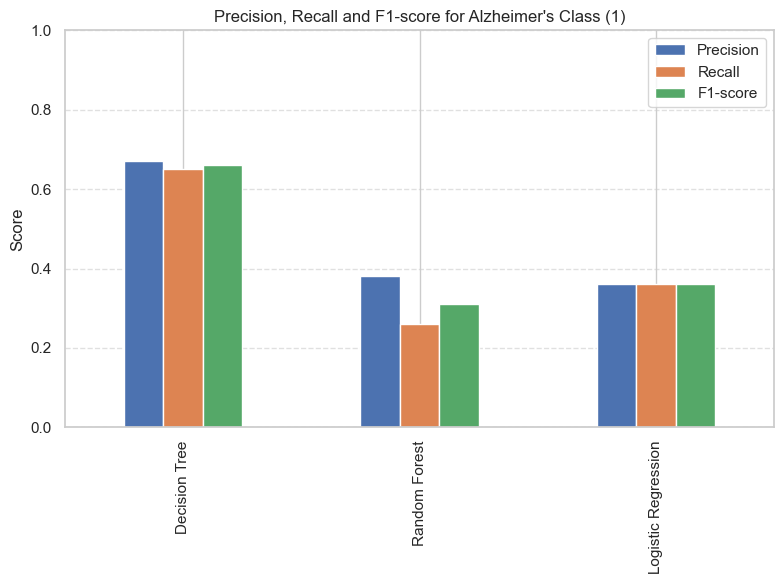

In [92]:
comparison_df.plot(kind="bar", figsize=(8, 6))
plt.title("Precision, Recall and F1-score for Alzheimer's Class (1)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This bar chart gives a clear comparison of model performance for detecting Alzheimer's patients.
We compare:

- Precision: How many predicted AD cases were correct

- Recall: How many real AD cases were detected

- F1-score: Balance between precision and recall

### Save the Plot

In [93]:
# Save the figure
fig = plt.gcf()
save_plot(
    fig,
    filename="class1_comparison_bar_chart.png",
    caption="Comparison of precision, recall and F1-score for class 1 (Alzheimer's) across three models.",
    folder_path="../plots"
)


Plot saved to: ../plots\class1_comparison_bar_chart.png
Caption saved to: ../plots\class1_comparison_bar_chart.txt


### Bar Chart Plot - zoomed only for 

<Figure size 800x600 with 0 Axes>

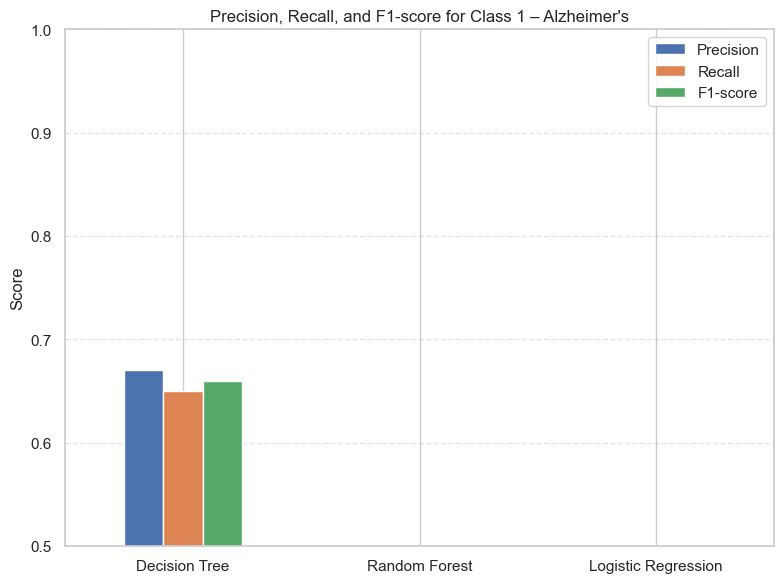

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot grouped bar chart
plt.figure(figsize=(8, 6))
comparison_df.plot(kind="bar", ylim=(0.5, 1.0), figsize=(8, 6))
plt.title("Precision, Recall, and F1-score for Class 1 – Alzheimer's")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Save the Comparison Plot

In [96]:
fig = plt.gcf()

from utils.save_tools import save_plot

save_plot(
    fig,
    filename="model_precision_recall_f1_bar_chart.png",
    caption="Comparison of precision, recall, and F1-score for predicting Alzheimer's (class 1) across all trained models.",
    folder_path="../plots"
)


Plot saved to: ../plots\model_precision_recall_f1_bar_chart.png
Caption saved to: ../plots\model_precision_recall_f1_bar_chart.txt


### What Do We See?
The Decision Tree performs the best on all three metrics for Alzheimer’s detection.

Random Forest and Logistic Regression score lower for this class, especially on recall, which means they miss more true Alzheimer’s cases.

This confirms that precision and recall are essential metrics when predicting a serious diagnosis, not just accuracy.

In [98]:
from utils.save_tools import save_notebook_and_summary
import sys
sys.path.append("..")

save_notebook_and_summary(
    notebook_name="04_model_training_and_evaluation",
    summary={
        "description": "Trained and evaluated three supervised classification models for Alzheimer's prediction.",
        "records_analyzed": X.shape[0],
        "features_used": X.shape[1],
        "models_trained": [
            "Decision Tree",
            "Random Forest",
            "Logistic Regression"
        ],
        "evaluation_metrics": [
            "Accuracy",
            "ROC AUC",
            "Confusion Matrix",
            "Precision, Recall, F1-score",
            "Feature Importance"
        ],
        "key_results": {
            "best_model": "Random Forest",
            "best_accuracy": round(rf_accuracy, 2),
            "best_auc": round(rf_auc, 2)
        },
        "output_file": "../data/model_results.csv"
    }
)


Summary saved to: ../reports\04_model_training_and_evaluation_summary_2025-06-14_12-07-51.json
